In [1]:
from BoxTheJets.aggregation import json_import_list, json_export_list
import numpy as np
from BoxTheJets.aggregation import Aggregator, get_subject_image, SOL
import matplotlib.pyplot as plt


Jet_clusters=json_import_list('BoxTheJets/exports/Jet_clusters_3.0_2.0_11-16_final.json')
subjects,date,end_date,ans,agreement,subject_file,subject_sol=np.loadtxt('subjects_{}_full.csv'.format('Tc'),delimiter=',',unpack=True,dtype=str)
subjects=subjects.astype(int)

Broken libmagic installation detected. The python-magic module is installed but can't be imported. Please check that both python-magic and the libmagic shared library are installed correctly. Uploading media other than images may not work.


The 1024 JetCluster objects are imported from BoxTheJets/exports/Jet_clusters_3.0_2.0_11-16_final.json.


In [2]:
from solar.database.tables import Visual_File

def get_imagefile(subject):
    subjectfile=subject_file[np.argwhere(subjects==subject)[0][0]]
    print(subjectfile)
    vv = Visual_File.select().where(Visual_File.file_name==subjectfile)
    return vv[0]

def get_subjects_Jetcluster(Jet_clusters,i):
    subjects=np.array([Jet_clusters[i].jets[j].subject for j in range(len(Jet_clusters[i].jets))])
    return subjects

def solar_conversion(vv,x,y):
    #Change de Y pixels to Height-Y since the pixel frame is defined inverted from the Zooniverse processor calcuation
    y=vv.height-y
    x_pix,y_pix=x,y
    wc = Visual_File.world_from_pixel(vv, float(x_pix), float(y_pix))
    solar_x,solar_y = wc.Tx,wc.Ty
    x_sun=str(solar_x).split('arcsec')[0]
    y_sun=str(solar_y).split('arcsec')[0]
    return float(x_sun),float(y_sun)

In [3]:
from panoptes_client import Panoptes, Subject
from skimage import io, transform

def get_subject_image(subject, frame=7,Hpix=1440,Wpix=1920):
    '''
        Fetch the subject image from Panoptes (Zooniverse database)

        Inputs
        ------
        subject : int
            Zooniverse subject ID
        frame : int
            Frame to extract (between 0-14, default 7)

        Outputs
        -------
        img : numpy.ndarray
            RGB image corresponding to `frame`
    '''
    # get the subject metadata from Panoptes
    subjecti = Subject(int(subject))
    try:
        frame0_url = subjecti.raw['locations'][frame]['image/png']
    except KeyError:
        frame0_url = subjecti.raw['locations'][frame]['image/jpeg']

    img = io.imread(frame0_url)

    #for subjects that have an odd size, resize them
    #if img.shape[0] != 1920:
    #    img = transform.resize(img, (Hpix, Wpix))

    return img

In [4]:
bx=np.array([Jet_clusters[i].Bx for i in range(len(Jet_clusters))])
W= np.array([Jet_clusters[i].Width for i in range(len(Jet_clusters))])
H= np.array([Jet_clusters[i].Height for i in range(len(Jet_clusters))])

In [5]:
d=np.argwhere((bx<50000) & (H<20000)& (bx<1000))

problems=np.array([],dtype=int)
for i in np.arange(len(bx)):
    if i not in d:
        #print(i)
        problems=np.append(problems,int(i))

print(len(problems))
print(problems)

195
[ 19  20  36  41  69  70  71 123 124 125 129 133 152 401 406 407 435 436
 437 456 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558
 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576
 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612
 613 614 615 616 617 618 619 620 621 640 725 726 727 728 818 822 823 824
 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842
 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860
 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878
 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896
 897 898 899 900 901 902 903 904 905 906 907 908 909 910 972]


In [6]:
problemJetClu=Jet_clusters[problems]
problemSOL=np.unique([Jet_clusters[i].SOL for i in problems])
print(len(problemSOL))
print(problemSOL)

18
['SOL2011-03-20T00:00:04L223C126' 'SOL2011-04-01T03:00:11L222C115'
 'SOL2011-05-27T07:40:18L038C079' 'SOL2011-11-28T07:30:00L223C061'
 'SOL2011-11-28T21:15:00L225C061' 'SOL2011-12-29T06:30:00L156C103'
 'SOL2011-12-30T09:00:04L212C085' 'SOL2012-03-08T21:15:00L011C061'
 'SOL2014-04-10T19:20:03L227C108' 'SOL2014-07-07T16:00:03L204C090'
 'SOL2014-11-28T21:00:03L218C102' 'SOL2015-07-07T17:00:06L068C061'
 'SOL2015-09-22T23:00:06L240C118' 'SOL2016-02-11T23:45:34L169C079'
 'SOL2016-02-16T00:00:06L116C072' 'SOL2016-02-18T00:00:06L069C082'
 'SOL2016-04-07T00:00:06L048C062' 'SOL2016-05-23T12:30:06L233C098']


In [7]:
from solar.database.tables import Fits_File
from solar.database.tables import Visual_File

testint=7
sol=problemSOL[testint]
subjects_JC= get_subjects_Jetcluster(Jet_clusters,testint)
fits=Fits_File.select().where(Fits_File.sol_standard == sol)
fits_header = fits[0].get_header_as_dict()
print('naxis1',fits_header['naxis1'],'naxis2',fits_header['naxis2'])
print('subject', Jet_clusters[testint].jets[0].subject)

naxis1 1462 naxis2 823
subject 70439040


In [22]:
#subjectfile=subject_file[np.argwhere(subjects==s)[0][0]]
#print(subjectfile)
#vv = Visual_File.select().where(Visual_File.file_name==subjectfile)
#vv[0].width

ssw_cutout_20110320_022308_aia_304_144.png


1241.0

naxis1 1167 naxis2 1252
ssw_cutout_20110320_091908_aia_304_560.png
70439072

    im_width = 1248.0,
    im_height = 936.0,
    im_ll_x = 0.24335363418530354,
    im_ll_y = 0.10999999999999999,
    im_ur_x = 0.7816463658146965,
    im_ur_y = 0.88


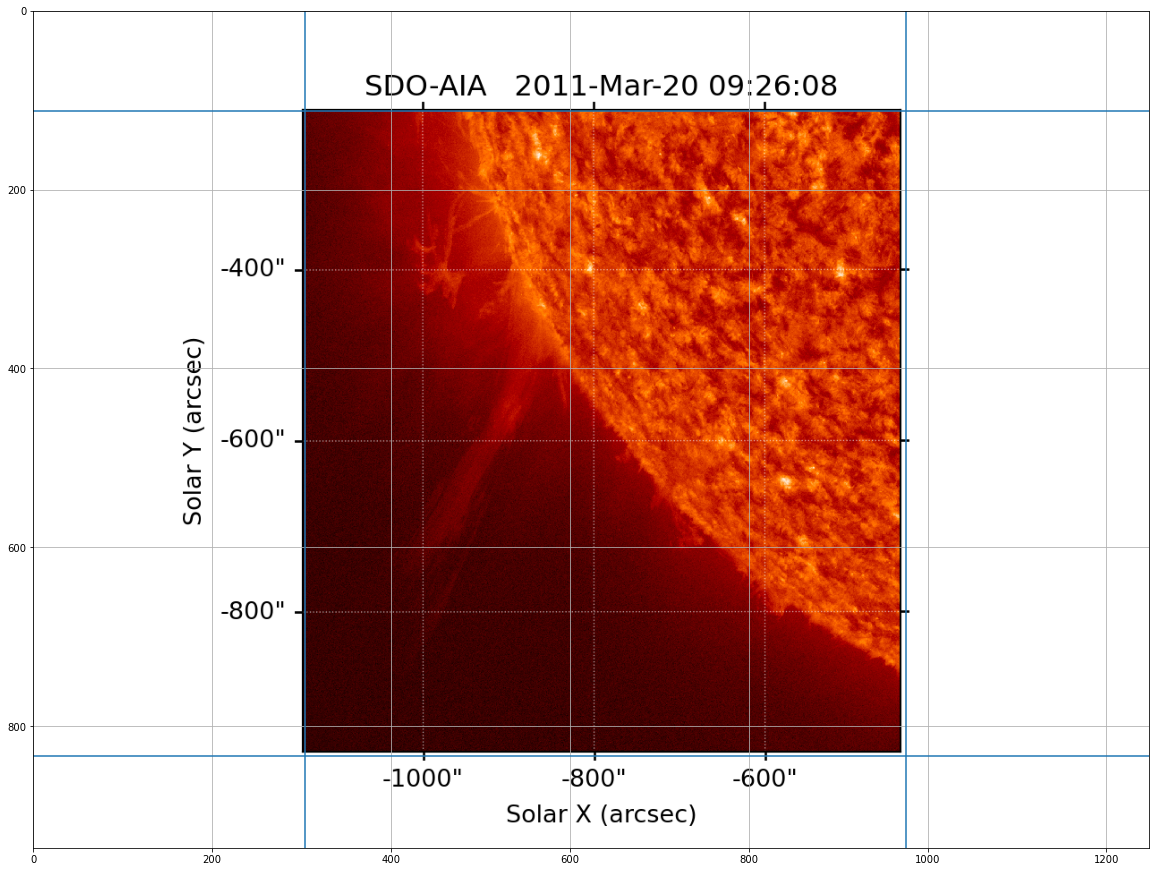

In [8]:
testint=20
subjects_JC= get_subjects_Jetcluster(Jet_clusters,testint)
sol=Jet_clusters[testint].SOL
fits=Fits_File.select().where(Fits_File.sol_standard == sol)
fits_header = fits[0].get_header_as_dict()
print('naxis1',fits_header['naxis1'],'naxis2',fits_header['naxis2'])

for s in subjects_JC:
    plt.figure(figsize=(20,20))
    vv= get_imagefile(s)
    plt.imshow(get_subject_image(s,Hpix=vv.height,Wpix=vv.width))
    print(s)

    print(f'''
    im_width = {vv.width},
    im_height = {vv.height},
    im_ll_x = {vv.im_ll_x},
    im_ll_y = {vv.im_ll_y},
    im_ur_x = {vv.im_ur_x},
    im_ur_y = {vv.im_ur_y}''')

    plt.hlines(vv.height-(vv.im_ll_y)*vv.height,0,vv.width) #A lot of them have offset +0.01
    plt.hlines(vv.height-(vv.im_ur_y)*vv.height,0,vv.width) #+0.01
    #im_  _x
    plt.vlines(vv.im_ll_x*vv.width,0,vv.height) 
    plt.vlines(vv.im_ur_x*vv.width,0,vv.height)

    plt.xlim(0,vv.width)
    plt.ylim(vv.height,0)

    plt.grid()
    plt.show()

In [15]:
#vv = Visual_File.select().where(Visual_File.file_name=='ssw_cutout_20110320_011808_aia_304_79.png')
#vv[0]

<vid: 79>

In [9]:
subject_id=70439072
Subject(subject_id).raw['locations'][7]['image/png']

'https://panoptes-uploads.zooniverse.org/subject_location/3e1ea8f2-d076-4186-a4e0-f6b90a69396b.png'

In [10]:
def get_subject_scale(subject_id):
    '''
        Get the scale for all frames for a given subject.
        Loads the subject from Panoptes and gets the image 
        sizes by directly opening the image
    '''
    try:
        # create the subject object 
        subject = Subject(subject_id)
        widths  = np.zeros(15)
        heights = np.zeros(15)
        vv= get_imagefile(subject_id)
        print(vv.width)
        
        # loop through the frames
        for frame in range(15):
            # get the image URL on panoptes
            try:
                frame_url = subject.raw['locations'][frame]['image/png']
            except KeyError:
                frame_url = subject.raw['locations'][frame]['image/jpeg']

            # read the image from the url 
            img = io.imread(frame_url)
            # and get its shape
            ny, nx, _ = img.shape

            widths[frame]  = nx
            heights[frame] = ny

        # the standard size is 1920x1440 so 
        # we will scale everything else to that size
        meta_width=subject.raw['metadata']['#width']
        print(meta_width)
        scale = widths/float(meta_width)  #1920.

        # add this info to the table
        data = [int(subject.id), *scale]
        
        return data
    except Exception as e:
        return None


In [11]:
get_subject_scale(70439072)

ssw_cutout_20110320_091908_aia_304_560.png
1248.0
1248.0


[70439072,
 1.0,
 0.9895833333333334,
 0.9943910256410257,
 0.9943910256410257,
 0.9895833333333334,
 0.9895833333333334,
 0.9895833333333334,
 0.9943910256410257,
 0.9839743589743589,
 0.9839743589743589,
 0.9839743589743589,
 1.0,
 0.9943910256410257,
 0.9943910256410257,
 0.9839743589743589]

(1440, 1920, 4)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from BoxTheJets.aggregation import Aggregator
plt.style.use('default')
from astropy.io import ascii

In [13]:
aggregator = Aggregator('BoxTheJets/reductions/point_reducer_hdbscan_box_the_jets.csv', 
                        'BoxTheJets/reductions/shape_reducer_hdbscan_box_the_jets.csv')
aggregator.load_extractor_data('BoxTheJets/extracts/point_extractor_by_frame_box_the_jets.csv',
                               'BoxTheJets/extracts/shape_extractor_rotateRectangle_box_the_jets.csv')


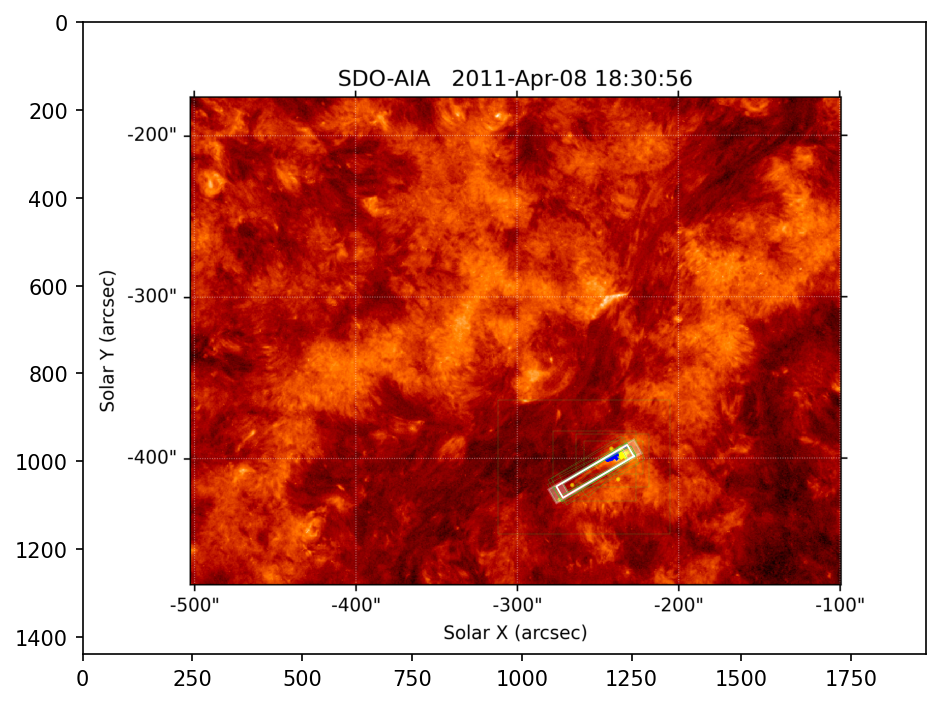

ssw_cutout_20110408_182808_aia_304_5117.png
in visual file 0.5208333333333334 0.5833333333333334
0.5208333333333334 0.5833333333333334 673 504 0.12692708333333336 0.10999999999999999 0.8980729166666667 0.88 0.5108064298257463 0.6147186147186148 343.77272727272725 309.81818181818187
(-296.359, -292.098)


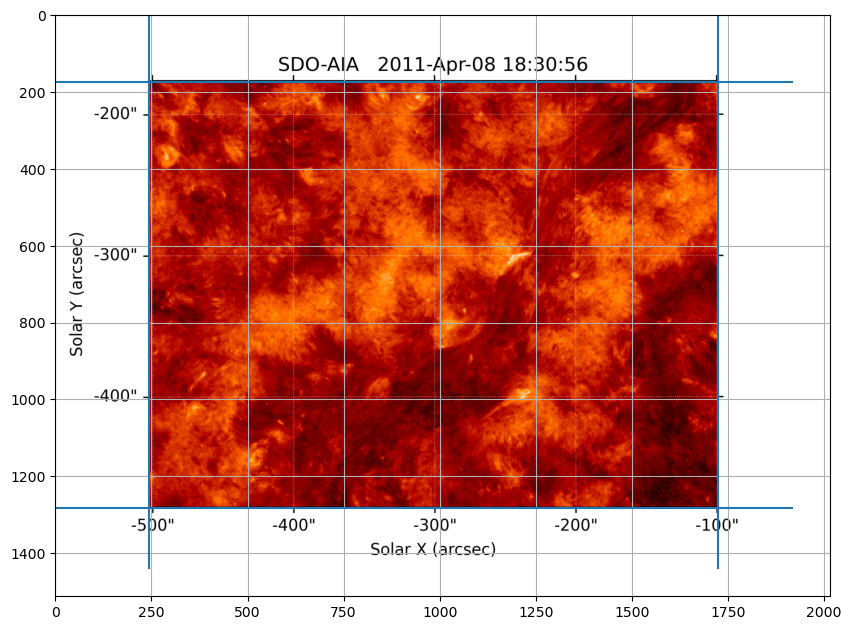

In [ ]:
testint=19
subjects_JC= get_subjects_Jetcluster(Jet_clusters,testint)

for subject in [subjects_JC]:
    ## check to make sure that these subjects had classification
    ## there's some subjects in this list that did not for some reason... (beta subjects?)
    subject_rows = aggregator.points_data[:][aggregator.points_data['subject_id']==subject[0]]
    nsubjects = len(subject_rows['data.frame0.T1_tool0_points_x'])

    if nsubjects > 0:
        aggregator.plot_subject(subject[0], task='T1')
    else:
        print(f"{subject[0]} has no classification data!")


    #get the new raw data
    #cx0_i = points_clusters['x_start']
    #cy0_i = points_clusters['y_start']
    #cx1_i = points_clusters['x_end']
    #cy1_i = points_clusters['y_end']


    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(get_subject_image(subject))
    plt.grid()
    vv= get_imagefile(subject)
    plt.imshow(get_subject_image(subject))
    #ax.scatter(cx0_i, cy0_i, 10.0, marker='x', color='blue')
    #ax.scatter(cx1_i, cy1_i, 10.0, marker='x', color='yellow')
    plt.hlines(vv.height-(vv.im_ll_y)*vv.height,0,vv.width) 
    plt.hlines(vv.height-(vv.im_ur_y)*vv.height,0,vv.width) 
    plt.vlines(vv.im_ll_x*vv.width,0,vv.height) 
    plt.vlines(vv.im_ur_x*vv.width,0,vv.height)

    print(solar_conversion(vv,1000,600))

    plt.show()

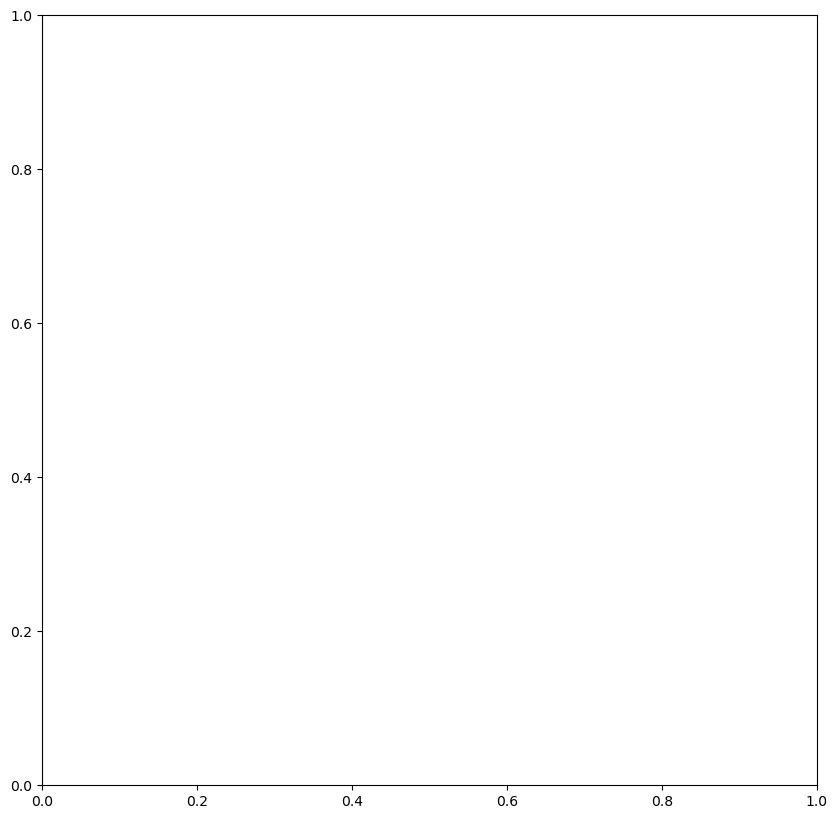